In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    RocCurveDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving hospital_readmissions.csv to hospital_readmissions.csv


In [ ]:
#health_df = pd.read_csv("healthcare_dataset.csv")
readmit_df = pd.read_csv("hospital_readmissions.csv")

In [ ]:
#health_df.head(5)

In [ ]:
readmit_df.head(10)

,age,time_in_hospital,n_lab_procedures,n_procedures,n_medications,n_outpatient,n_inpatient,n_emergency,medical_specialty,diag_1,diag_2,diag_3,glucose_test,A1Ctest,change,diabetes_med,readmitted
0,[70-80),8,72,1,18,2,0,0,Missing,Circulatory,Respiratory,Other,no,no,no,yes,no
1,[70-80),3,34,2,13,0,0,0,Other,Other,Other,Other,no,no,no,yes,no
2,[50-60),5,45,0,18,0,0,0,Missing,Circulatory,Circulatory,Circulatory,no,no,yes,yes,yes
3,[70-80),2,36,0,12,1,0,0,Missing,Circulatory,Other,Diabetes,no,no,yes,yes,yes
4,[60-70),1,42,0,7,0,0,0,InternalMedicine,Other,Circulatory,Respiratory,no,no,no,yes,no
5,[40-50),2,51,0,10,0,0,0,Missing,Other,Other,Other,no,no,no,no,yes
6,[50-60),4,44,2,21,0,0,0,Missing,Injury,Other,Other,no,normal,yes,yes,no
7,[60-70),1,19,6,16,0,0,1,Other,Circulatory,Other,Other,no,no,no,yes,yes
8,[80-90),4,67,3,13,0,0,0,InternalMedicine,Digestive,Other,Other,no,no,no,no,yes
9,[70-80),8,37,1,18,0,0,0,Family/GeneralPractice,Respiratory,Respiratory,Other,no,no,yes,yes,no


**EDA**

Dataset shape: (25000, 18)

Readmission rate:
y_readmit
0    0.53
1    0.47
Name: proportion, dtype: float64


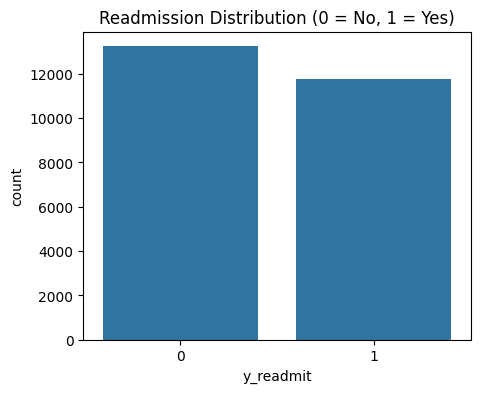


Numeric Feature Summary:
                    count      mean        std  min   25%   50%   75%    max
time_in_hospital  25000.0   4.45332   3.001470  1.0   2.0   4.0   6.0   14.0
n_lab_procedures  25000.0  43.24076  19.818620  1.0  31.0  44.0  57.0  113.0
n_procedures      25000.0   1.35236   1.715179  0.0   0.0   1.0   2.0    6.0
n_medications     25000.0  16.25240   8.060532  1.0  11.0  15.0  20.0   79.0
n_outpatient      25000.0   0.36640   1.195478  0.0   0.0   0.0   0.0   33.0
n_inpatient       25000.0   0.61596   1.177951  0.0   0.0   0.0   1.0   15.0
n_emergency       25000.0   0.18660   0.885873  0.0   0.0   0.0   0.0   64.0


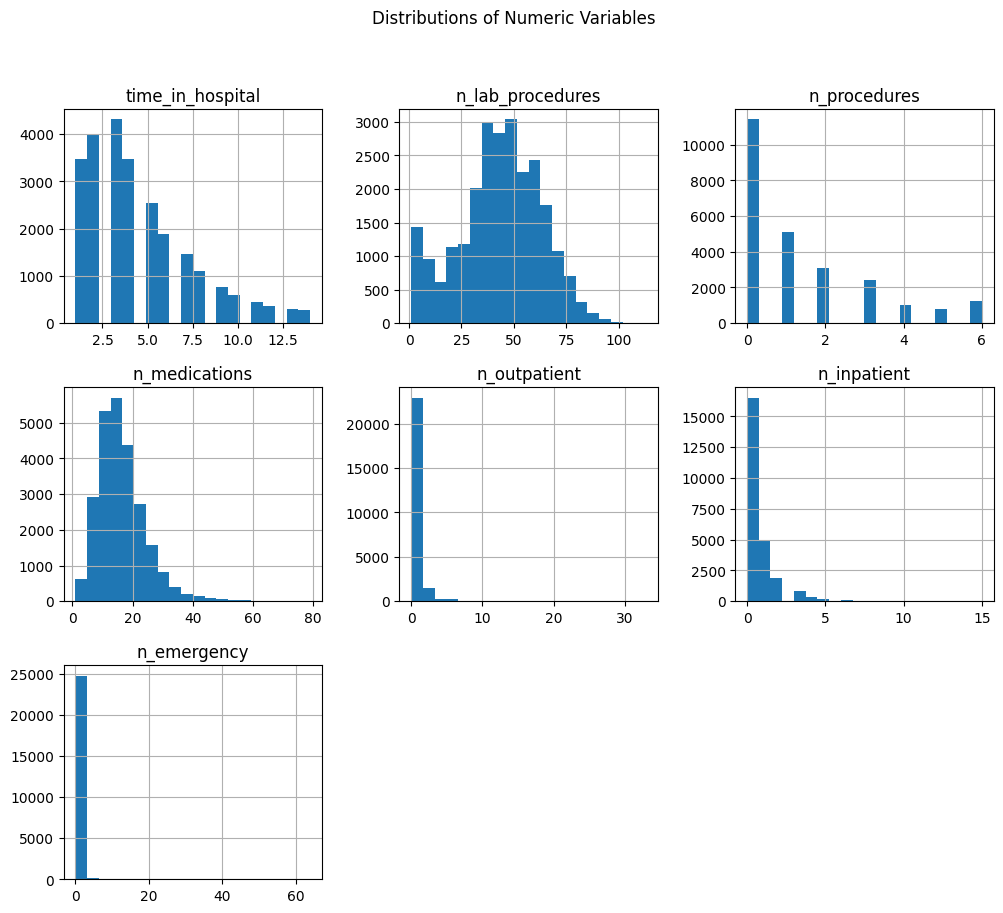


Age distribution:
age
[40-50)     2532
[50-60)     4452
[60-70)     5913
[70-80)     6837
[80-90)     4516
[90-100)     750
Name: count, dtype: int64


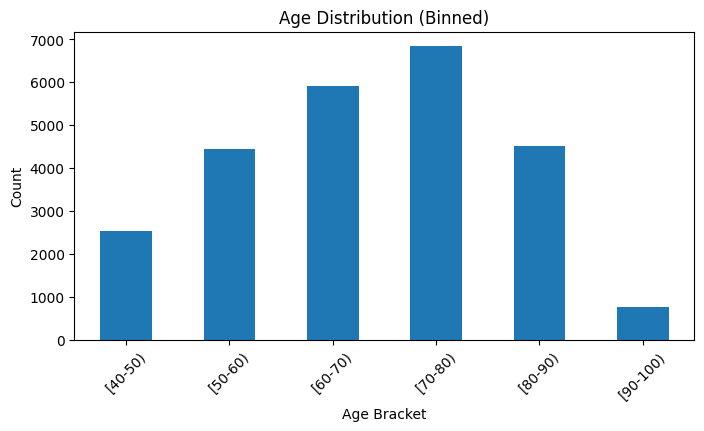


Top 10 most common primary diagnoses:
diag_1
Circulatory        7824
Other              6498
Respiratory        3680
Digestive          2329
Diabetes           1747
Injury             1666
Musculoskeletal    1252
Missing               4
Name: count, dtype: int64


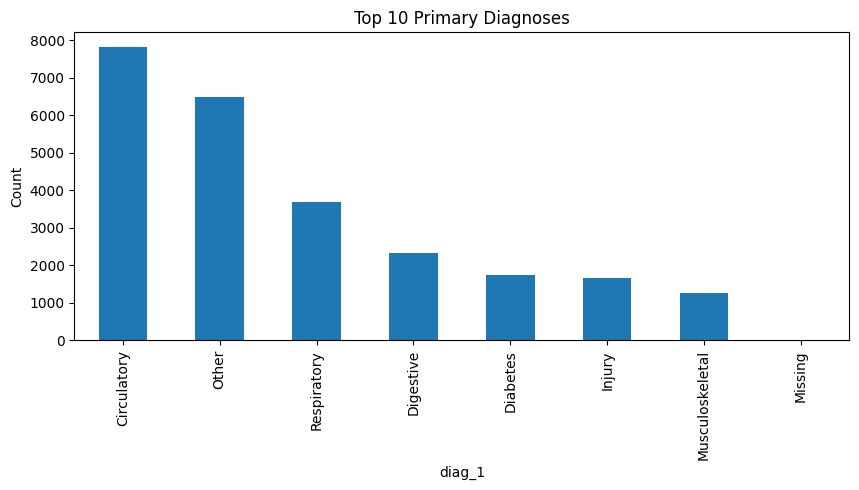

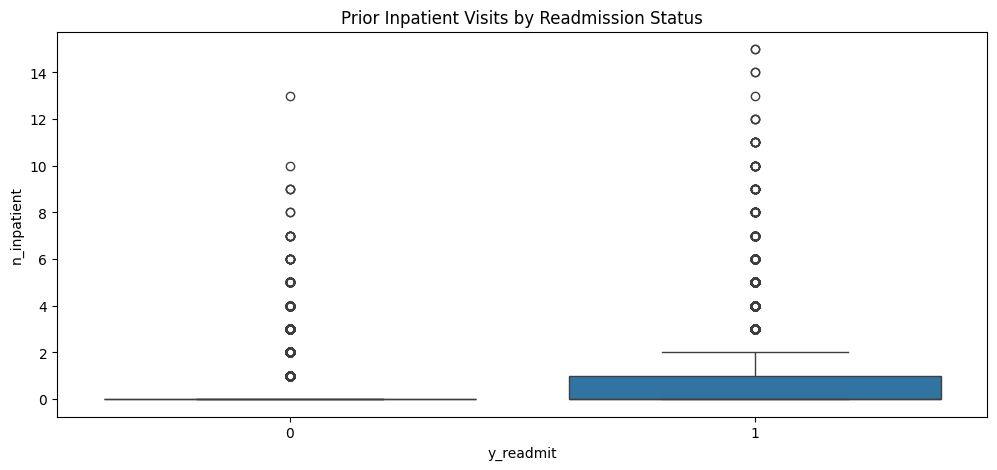


A1C test distribution:
glucose_test
no        23625
normal      689
high        686
Name: count, dtype: int64


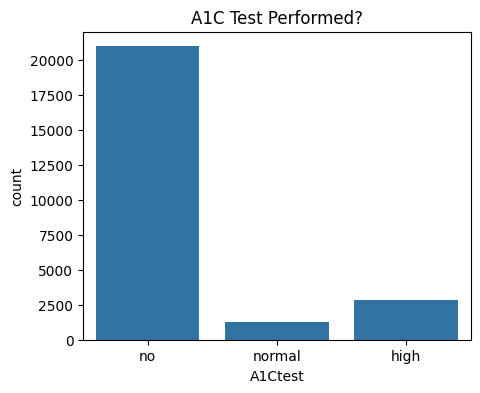

In [ ]:
# encode the target
readmit_df["y_readmit"] = readmit_df["readmitted"].map({
    "yes": 1,
    "no": 0
})

# basic shape & target distribution
print("Dataset shape:", readmit_df.shape)
print("\nReadmission rate:")
print(readmit_df["y_readmit"].value_counts(normalize=True).round(3))

# bar plot of target
plt.figure(figsize=(5,4))
sns.countplot(x="y_readmit", data=readmit_df)
plt.title("Readmission Distribution (0 = No, 1 = Yes)")
plt.show()


# summmary stats for numerical var
numeric_cols = [
    "time_in_hospital", "n_lab_procedures", "n_procedures",
    "n_medications", "n_outpatient", "n_inpatient", "n_emergency"
]

print("\nNumeric Feature Summary:")
print(readmit_df[numeric_cols].describe().T)

# histogram for key numeric features
readmit_df[numeric_cols].hist(figsize=(12, 10), bins=20)
plt.suptitle("Distributions of Numeric Variables")
plt.show()


# age distribution

print("\nAge distribution:")
print(readmit_df["age"].value_counts().sort_index())

plt.figure(figsize=(8,4))
readmit_df["age"].value_counts().sort_index().plot(kind="bar")
plt.title("Age Distribution (Binned)")
plt.xlabel("Age Bracket")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


# top diagnoses

diag_cols = ["diag_1", "diag_2", "diag_3"]

print("\nTop 10 most common primary diagnoses:")
print(readmit_df["diag_1"].value_counts().head(10))

plt.figure(figsize=(10,4))
readmit_df["diag_1"].value_counts().head(10).plot(kind="bar")
plt.title("Top 10 Primary Diagnoses")
plt.ylabel("Count")
plt.show()


# utilization by readmission

plt.figure(figsize=(12,5))
sns.boxplot(x="y_readmit", y="n_inpatient", data=readmit_df)
plt.title("Prior Inpatient Visits by Readmission Status")
plt.show()

# lab test flags

print("\nA1C test distribution:")
print(readmit_df["A1Ctest"].value_counts())

plt.figure(figsize=(5,4))
sns.countplot(x="A1Ctest", data=readmit_df)
plt.title("A1C Test Performed?")
plt.show()

**CART MODEL**

Numeric columns: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
Categorical columns: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
Fitting 5 folds for each of 180 candidates, totalling 900 fits
Best params: {'cart__ccp_alpha': 0.0005, 'cart__max_depth': 5, 'cart__min_samples_leaf': 1, 'cart__min_samples_split': 2}
Best CV ROC-AUC: 0.6306577459827591

Test ROC-AUC: 0.6340965724809038

Confusion matrix:
 [[1702  947]
 [1032 1319]]

Classification report:
               precision    recall  f1-score   support

           0       0.62      0.64      0.63      2649
           1       0.58      0.56      0.57      2351

    accuracy                           0.60      5000
   macro avg       0.60      0.60      0.60      5000
weighted avg       0.60      0.60      0.60      5000



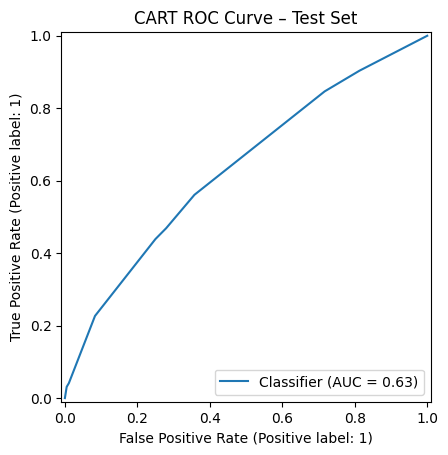


Top 20 features by importance:
                                     feature  importance
52                               n_inpatient    0.807468
51                              n_outpatient    0.087709
53                               n_emergency    0.044366
45                           diabetes_med_no    0.039782
1                                age_[50-60)    0.020675
0                                age_[40-50)    0.000000
6               medical_specialty_Cardiology    0.000000
7         medical_specialty_Emergency/Trauma    0.000000
8   medical_specialty_Family/GeneralPractice    0.000000
9         medical_specialty_InternalMedicine    0.000000
10                 medical_specialty_Missing    0.000000
11                   medical_specialty_Other    0.000000
12                 medical_specialty_Surgery    0.000000
13                        diag_1_Circulatory    0.000000
14                           diag_1_Diabetes    0.000000
15                          diag_1_Digestive    0.000000

In [ ]:
# Define X and y for the CART model
feature_cols = [
    "age", "time_in_hospital", "n_lab_procedures", "n_procedures",
    "n_medications", "n_outpatient", "n_inpatient", "n_emergency",
    "medical_specialty", "diag_1", "diag_2", "diag_3",
    "glucose_test", "A1Ctest", "change", "diabetes_med"
]
X = readmit_df[feature_cols]
y = readmit_df["y_readmit"]

# 2. Train / test split (stratified)
X_trainval, X_test_cart, y_trainval, y_test_cart = train_test_split( # Renamed X_test, y_test to avoid conflicts
    X, y,
    test_size=0.2,
    random_state=142,
    stratify=y
)

# 3. Preprocessing: numeric vs categorical cols
# # In your readmissions dataset:
#   numeric: time_in_hospital, n_lab_procedures, n_procedures, n_medications,
#            n_outpatient, n_inpatient, n_emergency
#   categorical: age, medical_specialty, diag_1, diag_2, diag_3, glucose_test,
#                A1Ctest, change, diabetes_med

numeric_cols = X_trainval.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_trainval.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols),
    ]
)

# 4. CART model + pipeline
cart = DecisionTreeClassifier(
    random_state=142,
    class_weight="balanced"
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("cart", cart),
])

# 5. Hyperparameter tuning with CV
param_grid = {
    "cart__max_depth": [3, 5, 7, 9, None],
    "cart__min_samples_split": [2, 10, 50],
    "cart__min_samples_leaf": [1, 5, 20],
    "cart__ccp_alpha": [0.0, 0.0005, 0.001, 0.01],
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring="roc_auc",  # main metric we’re optimizing
    n_jobs=-1,
    verbose=1
)

grid.fit(X_trainval, y_trainval)

print("Best params:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)

# 6. Evaluate on held-out test set
cart_best_model = grid.best_estimator_ # Renamed to cart_best_model

cart_y_proba = cart_best_model.predict_proba(X_test_cart)[:, 1] # Renamed y_proba
cart_y_pred = cart_best_model.predict(X_test_cart) # Renamed y_pred

print("\nTest ROC-AUC:", roc_auc_score(y_test_cart, cart_y_proba))
print("\nConfusion matrix:\n", confusion_matrix(y_test_cart, cart_y_pred))
print("\nClassification report:\n", classification_report(y_test_cart, cart_y_pred))

RocCurveDisplay.from_predictions(y_test_cart, cart_y_proba)
plt.title("CART ROC Curve – Test Set")
plt.show()

# 7. Top feature importances
onehot = cart_best_model.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[cat_feature_names, numeric_cols]

tree = cart_best_model.named_steps["cart"]
importances = tree.feature_importances_

feat_imp = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(20)
)

print("\nTop 20 features by importance:")
print(feat_imp)

**LOGISTIC REGRESSION MODEL: Predicting whether a patient will be readmitted to the hospital**

Training+Validation set size: 20000
Test set size: 5000
Class distribution:
y_readmit
0    0.52985
1    0.47015
Name: proportion, dtype: float64

Numeric columns (7): ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
Categorical columns (9): ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
Optimization terminated successfully.
         Current function value: 0.654124
         Iterations: 231
         Function evaluations: 232
         Gradient evaluations: 232
LOGISTIC REGRESSION MODEL SUMMARY
                           Logit Regression Results                           
Dep. Variable:              y_readmit   No. Observations:                20000
Model:                          Logit   Df Residuals:                    19954
Method:                           MLE   Df Model:                           45
Date:                Tue, 02 Dec 2025   Pseudo R-sq

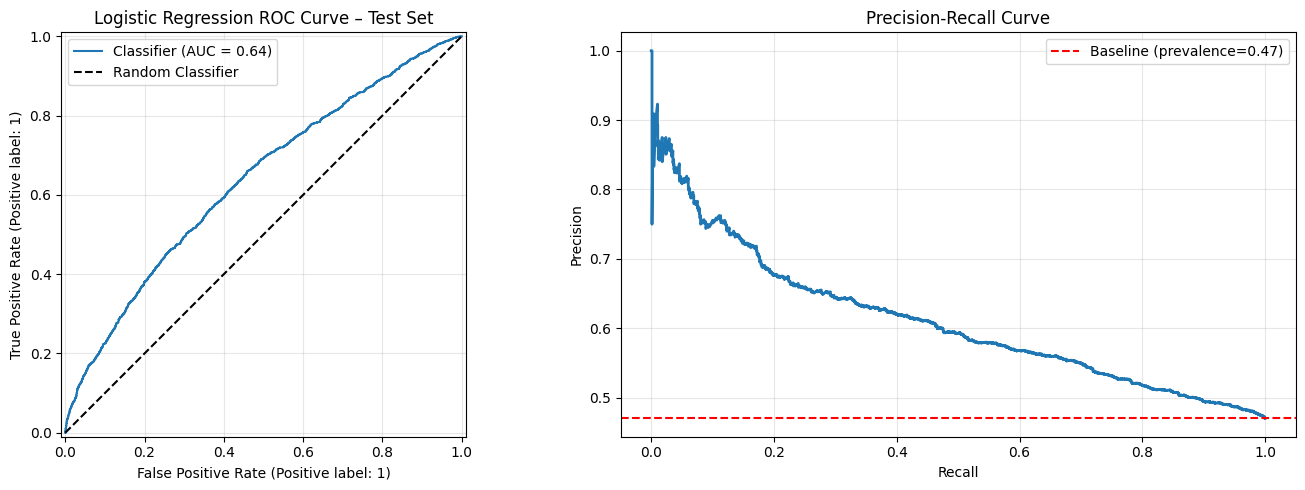

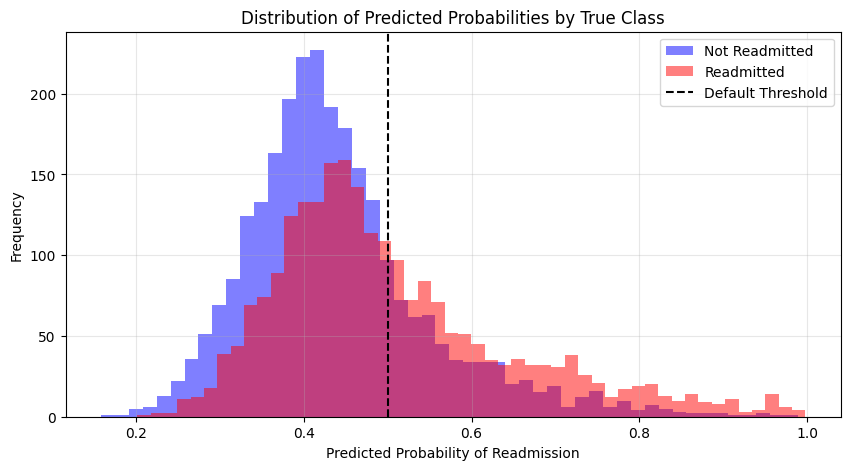


FINAL SUMMARY
Model: Logistic Regression (Statsmodels)
Test ROC-AUC: 0.6357
Test Accuracy: 0.6026


In [ ]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    RocCurveDisplay,
    precision_recall_curve
)

# 1. Preparing target variable
readmit_df["y_readmit"] = readmit_df["readmitted"].map({
    "yes": 1,  # readmitted (yes)
    "no": 0    # NOT readmitted (no)
})

# 2. Define feature columns (all available predictors)
feature_cols = [
    "age", "time_in_hospital", "n_lab_procedures", "n_procedures",
    "n_medications", "n_outpatient", "n_inpatient", "n_emergency",
    "medical_specialty", "diag_1", "diag_2", "diag_3",
    "glucose_test", "A1Ctest", "change", "diabetes_med"
]

X = readmit_df[feature_cols]
y = readmit_df["y_readmit"]

# 3. TRAIN/TEST SPLIT
X_trainval, X_test_log_reg, y_trainval, y_test_log_reg = train_test_split( # Renamed X_test, y_test
    X,
    y,
    test_size=0.2,
    random_state=88,
    stratify=y
)

print(f"Training+Validation set size: {len(X_trainval)}")
print(f"Test set size: {len(X_test_log_reg)}")
print(f"Class distribution:\n{y_trainval.value_counts(normalize=True)}")

# 4. Identify numeric & categorical columns
numeric_cols = X_trainval.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_trainval.columns if c not in numeric_cols]

print(f"\nNumeric columns ({len(numeric_cols)}): {numeric_cols}")
print(f"Categorical columns ({len(categorical_cols)}): {categorical_cols}")

# 5. One-hot encode categorical variables
X_train_encoded = pd.get_dummies(
    X_trainval,
    columns=categorical_cols,
    drop_first=True
)
X_test_encoded = pd.get_dummies(
    X_test_log_reg, # Use renamed X_test
    columns=categorical_cols,
    drop_first=True
)

# Align columns (in case test set is missing some categories)
X_test_encoded = X_test_encoded.reindex(
    columns=X_train_encoded.columns,
    fill_value=0
)

# 6. Standardize numeric variables
scaler = StandardScaler()
X_train_scaled = X_train_encoded.copy()
X_test_scaled = X_test_encoded.copy()

X_train_scaled[numeric_cols] = scaler.fit_transform(
    X_train_encoded[numeric_cols]
)
X_test_scaled[numeric_cols] = scaler.transform(
    X_test_encoded[numeric_cols]
)

# 7. Add constant for intercept
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Ensure all data passed to statsmodels is float
X_train_sm = X_train_scaled.astype(float)
X_test_sm = X_test_scaled.astype(float)
y_train_sm = y_trainval.astype(float)

# 8. BUILD LOGISTIC REGRESSION PIPELINE
logit_model = sm.Logit(y_train_sm, X_train_sm)
result = logit_model.fit(method="bfgs", maxiter=1000)

print("LOGISTIC REGRESSION MODEL SUMMARY")
print(result.summary())

# 9. TEST SET EVALUATION
log_reg_y_proba = result.predict(X_test_sm) # Renamed y_proba
log_reg_y_pred = (log_reg_y_proba >= 0.5).astype(int) # Renamed y_pred

print("\n" + "=" * 60)
print("TEST SET PERFORMANCE")
print("=" * 60)
print(f"Test ROC-AUC: {roc_auc_score(y_test_log_reg, log_reg_y_proba):.4f}")
print(f"Test Accuracy: {(log_reg_y_pred == y_test_log_reg).mean():.4f}")

print(f"\nConfusion Matrix:")
cm = confusion_matrix(y_test_log_reg, log_reg_y_pred)
print(cm)
print(f"True Negatives: {cm[0, 0]}, False Positives: {cm[0, 1]}")
print(f"False Negatives: {cm[1, 0]}, True Positives: {cm[1, 1]}")

# Calculate metrics
tn, fp, fn, tp = cm.ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
precision = tp / (tp + fp)
f1 = 2 * (precision * sensitivity) / (precision + sensitivity)

print(f"\nPerformance Metrics:")
print(f"  Sensitivity (Recall): {sensitivity:.4f}")
print(f"  Specificity: {specificity:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  F1-Score: {f1:.4f}")

# 10. ROC AND PRECISION-RECALL CURVES
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ROC Curve
RocCurveDisplay.from_predictions(y_test_log_reg, log_reg_y_proba, ax=axes[0])
axes[0].plot([0, 1], [0, 1], "k--", label="Random Classifier")
axes[0].set_title("Logistic Regression ROC Curve – Test Set")
axes[0].legend()
axes[0].grid(alpha=0.3)

# Precision-Recall Curve
precision_vals, recall_vals, thresholds = precision_recall_curve(y_test_log_reg, log_reg_y_proba)
axes[1].plot(recall_vals, precision_vals, linewidth=2)
axes[1].set_xlabel("Recall")
axes[1].set_ylabel("Precision")
axes[1].set_title("Precision-Recall Curve")
axes[1].axhline(
    y=y_test_log_reg.mean(),
    color="r",
    linestyle="--",
    label=f"Baseline (prevalence={y_test_log_reg.mean():.2f})"
)
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 11. PREDICTED PROBABILITY DISTRIBUTION
plt.figure(figsize=(10, 5))
plt.hist(
    log_reg_y_proba[y_test_log_reg == 0],
    bins=50,
    alpha=0.5,
    label="Not Readmitted",
    color="blue"
)
plt.hist(
    log_reg_y_proba[y_test_log_reg == 1],
    bins=50,
    alpha=0.5,
    label="Readmitted",
    color="red"
)
plt.xlabel("Predicted Probability of Readmission")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Probabilities by True Class")
plt.axvline(x=0.5, color="black", linestyle="--", label="Default Threshold")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

print("\n" + "=" * 60)
print("FINAL SUMMARY")
print("=" * 60)
print("Model: Logistic Regression (Statsmodels)")
print(f"Test ROC-AUC: {roc_auc_score(y_test_log_reg, log_reg_y_proba):.4f}")
print(f"Test Accuracy: {(log_reg_y_pred == y_test_log_reg).mean():.4f}")
print("=" * 60)

**RANDOM FORESTS MODEL**

Numeric columns: ['time_in_hospital', 'n_lab_procedures', 'n_procedures', 'n_medications', 'n_outpatient', 'n_inpatient', 'n_emergency']
Categorical columns: ['age', 'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'glucose_test', 'A1Ctest', 'change', 'diabetes_med']
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best parameters: {'rf__max_depth': 10, 'rf__min_samples_leaf': 1, 'rf__min_samples_split': 10, 'rf__n_estimators': 200}
Best CV ROC-AUC: 0.6578332943536178

Test ROC-AUC: 0.6529989166317024

Confusion Matrix:
 [[1782  867]
 [1063 1288]]

Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.67      0.65      2649
           1       0.60      0.55      0.57      2351

    accuracy                           0.61      5000
   macro avg       0.61      0.61      0.61      5000
weighted avg       0.61      0.61      0.61      5000



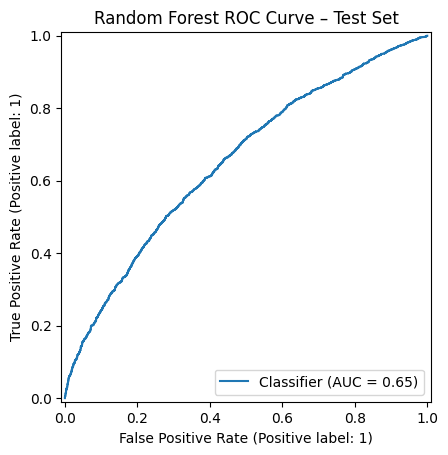


Top 20 Feature Importances:
                               feature  importance
52                         n_inpatient    0.242683
50                       n_medications    0.086125
51                        n_outpatient    0.080630
48                    n_lab_procedures    0.077590
53                         n_emergency    0.058345
47                    time_in_hospital    0.050540
49                        n_procedures    0.036501
45                     diabetes_med_no    0.013430
46                    diabetes_med_yes    0.012491
4                          age_[80-90)    0.011924
19                        diag_1_Other    0.011700
3                          age_[70-80)    0.011573
10           medical_specialty_Missing    0.011475
1                          age_[50-60)    0.010893
35                        diag_3_Other    0.009859
9   medical_specialty_InternalMedicine    0.009809
21                  diag_2_Circulatory    0.009687
11             medical_specialty_Other    0.009666
29

In [ ]:
#YES/NO Target
# =========================================================
# RANDOM FOREST MODEL – Predicting Hospital Readmission
# =========================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    roc_auc_score,
    confusion_matrix,
    classification_report,
    RocCurveDisplay
)


# ---------------------------------------------------------
# 1. Encode target (yes = 1, no = 0)
# ---------------------------------------------------------
readmit_df["y_readmit"] = readmit_df["readmitted"].map({
    "yes": 1,
    "no": 0
})


# ---------------------------------------------------------
# 2. Select feature columns
# ---------------------------------------------------------
feature_cols = [
    "age", "time_in_hospital", "n_lab_procedures", "n_procedures",
    "n_medications", "n_outpatient", "n_inpatient", "n_emergency",
    "medical_specialty", "diag_1", "diag_2", "diag_3",
    "glucose_test", "A1Ctest", "change", "diabetes_med"
]

X = readmit_df[feature_cols]
y = readmit_df["y_readmit"]


# ---------------------------------------------------------
# 3. Train–test split (stratified)
# ---------------------------------------------------------
X_trainval, X_test_rf, y_trainval, y_test_rf = train_test_split( # Renamed X_test, y_test
    X, y,
    test_size=0.2,
    random_state=142,
    stratify=y
)


# ---------------------------------------------------------
# 4. Identify numeric and categorical columns
# ---------------------------------------------------------
numeric_cols = X_trainval.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X_trainval.columns if c not in numeric_cols]

print("Numeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)


# ---------------------------------------------------------
# 5. Preprocessing pipeline
# ---------------------------------------------------------
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
        ("num", "passthrough", numeric_cols)
    ]
)


# ---------------------------------------------------------
# 6. Random Forest model + pipeline
# ---------------------------------------------------------
rf = RandomForestClassifier(
    random_state=142,
    class_weight="balanced",
    n_jobs=1   # prevents memory crashes in Google Colab
)

pipe = Pipeline(steps=[
    ("prep", preprocess),
    ("rf", rf)
])


# ---------------------------------------------------------
# 7. Hyperparameter tuning (optimized for Colab runtime)
# ---------------------------------------------------------
param_grid = {
    "rf__n_estimators": [200],          # enough trees for stable results
    "rf__max_depth": [None, 10],
    "rf__min_samples_split": [2, 10],
    "rf__min_samples_leaf": [1, 5]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=142)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring="roc_auc",
    cv=cv,
    n_jobs=1,      # prevents "worker stopped" memory issues
    verbose=1
)


# ---------------------------------------------------------
# 8. Fit the Random Forest model
# ---------------------------------------------------------
grid.fit(X_trainval, y_trainval)

print("Best parameters:", grid.best_params_)
print("Best CV ROC-AUC:", grid.best_score_)


# ---------------------------------------------------------
# 9. Evaluate on test set
# ---------------------------------------------------------
rf_best_model = grid.best_estimator_ # Renamed best_model

rf_y_proba = rf_best_model.predict_proba(X_test_rf)[:, 1] # Renamed y_proba
rf_y_pred = rf_best_model.predict(X_test_rf) # Renamed y_pred

print("\nTest ROC-AUC:", roc_auc_score(y_test_rf, rf_y_proba))
print("\nConfusion Matrix:\n", confusion_matrix(y_test_rf, rf_y_pred))
print("\nClassification Report:\n", classification_report(y_test_rf, rf_y_pred))

RocCurveDisplay.from_predictions(y_test_rf, rf_y_proba)
plt.title("Random Forest ROC Curve – Test Set")
plt.show()


# ---------------------------------------------------------
# 10. Feature Importance (top 20)
# ---------------------------------------------------------
# Get names from one-hot encoded features
onehot = rf_best_model.named_steps["prep"].named_transformers_["cat"]
cat_feature_names = onehot.get_feature_names_out(categorical_cols)
all_feature_names = np.r_[cat_feature_names, numeric_cols]

tree = rf_best_model.named_steps["rf"]
importances = tree.feature_importances_

feat_imp = (
    pd.DataFrame({"feature": all_feature_names, "importance": importances})
      .sort_values("importance", ascending=False)
      .head(20)
)

print("\nTop 20 Feature Importances:")
print(feat_imp)



**MODEL COMPARISON ANALYSIS**



      PERFORMANCE COMPARISON TABLE
                 Model   ROC-AUC  Accuracy  Precision    Recall  Specificity  \
0  Logistic Regression  0.635665    0.6026   0.619895  0.400255     0.782182   
1        Random Forest  0.500668    0.5012   0.466821  0.427903     0.566251   
2   CART Decision Tree  0.485823    0.4966   0.463372  0.446618     0.540959   

   F1 Score  
0  0.486431  
1  0.446516  
2  0.454841  


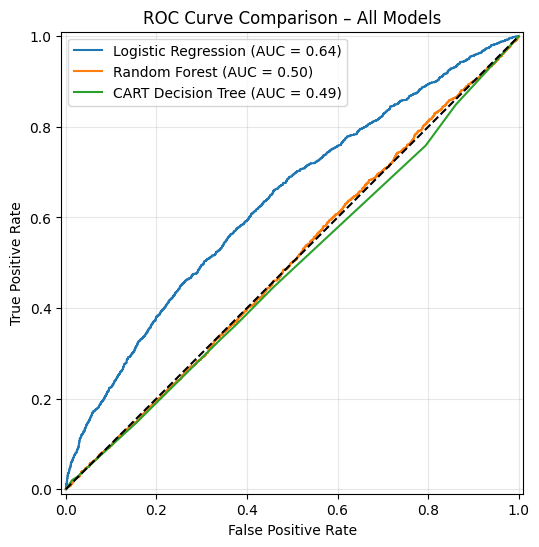

In [ ]:
# ============================================
# MODEL COMPARISON: LOGISTIC REG, RANDOM FOREST, CART
# ============================================

import pandas as pd
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, RocCurveDisplay
)
import matplotlib.pyplot as plt


# ----------------------------------------------------
# 1. COLLECT PREDICTIONS FROM EACH MODEL
# ----------------------------------------------------
# Ensure X_test and y_test are consistently defined, e.g., from Logistic Regression cell.
# Assuming y_test_log_reg, log_reg_y_proba, log_reg_y_pred are available from cell zk8OAYoaL6bV
# Assuming X_test_rf, rf_y_proba, rf_y_pred, rf_best_model are available from cell BQul5vQYL5xt
# Assuming X_test_cart, cart_y_proba, cart_y_pred, cart_best_model are available from cell 0ET70AkPL7xi

# Define y_test for comparison (using the one from Logistic Regression as a standard)
y_test_comparison = y_test_log_reg

### LOGISTIC REGRESSION ###
log_proba = log_reg_y_proba
log_pred = log_reg_y_pred


### RANDOM FOREST ###
rf_pred = rf_y_pred
rf_proba = rf_y_proba


### CART (Decision Tree) ###
cart_pred = cart_y_pred
cart_proba = cart_y_proba


# ----------------------------------------------------
# 2. FUNCTION TO COMPUTE METRICS
# ----------------------------------------------------
def evaluate_model(name, y_true, y_pred, y_proba):
    """Computes all major classification metrics for comparison."""
    auc = roc_auc_score(y_true, y_proba)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    specificity = tn / (tn + fp)

    return {
        "Model": name,
        "ROC-AUC": auc,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1 Score": f1
    }


# ----------------------------------------------------
# 3. COMPUTE METRICS FOR ALL 3 MODELS
# ----------------------------------------------------
results = []

results.append(evaluate_model("Logistic Regression", y_test_comparison, log_pred, log_proba))
results.append(evaluate_model("Random Forest", y_test_comparison, rf_pred, rf_proba))
results.append(evaluate_model("CART Decision Tree", y_test_comparison, cart_pred, cart_proba))

results_df = pd.DataFrame(results)

print("\n====================================")
print("      PERFORMANCE COMPARISON TABLE")
print("====================================")
print(results_df)


# ----------------------------------------------------
# 4. PLOT ROC CURVES TOGETHER
# ----------------------------------------------------
plt.figure(figsize=(8,6))

RocCurveDisplay.from_predictions(y_test_comparison, log_proba, name="Logistic Regression", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_comparison, rf_proba, name="Random Forest", ax=plt.gca())
RocCurveDisplay.from_predictions(y_test_comparison, cart_proba, name="CART Decision Tree", ax=plt.gca())

plt.plot([0,1], [0,1], "k--")  # baseline
plt.title("ROC Curve Comparison – All Models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.grid(alpha=0.3)
plt.legend()
plt.show()